In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn.datasets as skdata
import scipy.optimize as optimize
import math
import scipy.stats as sts
from rvm_class import RVM_reg
from svm_reg_class import SVM_reg
from collections import deque
from numpy import linalg
dirData = 'Data/'

# Hyperparameter tuning functions

In [ ]:
def createFolds(X, N = 5):
    """ Seperates data in N folds preparing the data for N-fold CV.
    
    Args:
        X: matrix with input data
        N: number of folds
        
    Returns:
        A list with N tuples. Each tuple has a list of indices for the training data
        and a list of indices for the validation data..
    """
    input_size = X.shape[0]
    indices = [i for i in range(input_size)]
    chunk_size = int(input_size / N)

    fold_list = []
    for i in range(N):
        training_indices = []
        for i in range(0, input_size - chunk_size, chunk_size):
            training_indices.extend(indices[i:i + chunk_size])
        validation_indices = indices[input_size - chunk_size: input_size]
        fold_list.append((training_indices, validation_indices))
        # Put validation data in the front so that it is training data on the next fold
        indices = validation_indices + training_indices
    return fold_list

In [ ]:
def tune_hyperparams(X, Y, params, model_type, N = 5, rvmType = "EM", svmType = 'C', kerType = "radial"):
    """ Hyperparameter tuning using a grid search and N-fold CV.
    
    Args:
        X: matrix with input data
        Y: vector with output data
        params: list of lists with the possible values for each parameter
        model_type: name of the model to be used
        N: number of folds
        rvmType: type of rvm (EM,DD,SSBL) in case model_type is "rvm"
        svmType: type of svm (C or V)
        kerType: type of kernel
        
    Returns:
        A tuple with the parameters that achieved the best performance.
        
    """
    
    fold_indices = createFolds(X, N)
    min_error = 1e+50
    if model_type == "svm_reg":
        C_idx, eps_idx, sigma_idx = (-1, -1, -1)
        # For each combination of parameters
        for idx1, C in enumerate(params[0]):
            for idx2, epsilon in enumerate(params[1]):
                for idx3, sigma in enumerate(params[2]):
                    # Do N-fold CV
                    error = 0
                    try:
                        for i in range(N):
                            train_indices, val_indices = fold_indices[i]
                            X_tr = X[train_indices]
                            Y_tr = Y[train_indices]
                            X_val = X[val_indices]
                            Y_val = Y[val_indices]
                            svm = SVM_reg(svmType = svmType, kerType = kerType, C = C, eps = epsilon,  sigma = sigma)
                            svm.train(X_tr, Y_tr)
                            Y_pred = svm.pred(X_val)
                            error += np.sum(np.abs(Y_pred - Y_val)) / Y_val.shape[0]
                    except Exception as e:
                        print(e)
                        continue

                    if error / N < min_error:
                        C_idx = idx1
                        eps_idx = idx2
                        sigma_idx = idx3
                        min_error = error / N
                
        return (C_idx, eps_idx, sigma_idx)
    elif model_type == "rvm_reg":
        sigma_idx = -1
        # For each gaussian kernel sigma
        for idx1, sigma in enumerate(params[0]):
            # Do N-fold CV
            error = 0
            try:
                for i in range(N):
                    train_indices, val_indices = fold_indices[i]
                    X_tr = X[train_indices]
                    Y_tr = Y[train_indices]
                    X_val = X[val_indices]
                    Y_val = Y[val_indices]
                    rvm = RVM_reg(rvmType = rvmType, kerType = kerType, sigma = sigma)
                    rvm.train(X_tr, Y_tr)
                    Y_pred, error_var = rvm.pred(X_val)
                    error += np.sum(np.abs(Y_pred - Y_val)) / Y_val.shape[0]
            except Exception as e:
                print(e)
                continue

            if error / N < min_error:
                sigma_idx = idx1
                min_error = error / N
        return (sigma_idx)
        

   
                        

# Regression Data

## Custom transformations

In [ ]:
def trans(x):
    N = np.shape(x)[0]
    y = np.sin(x) + 3 + np.random.normal(loc=0, scale=0.3, size=N)
    return y

In [ ]:
def transPoly(x):
    N = np.shape(x)[0]
    y = 0.05*x**3 - 0.35*x**2 + np.random.normal(loc=0, scale=0.1, size=N)
    return y

## Sinc with uniform error [-0.1, 0.1]

In [ ]:
def Sinc2(N, x0, xN, n0, nN, norm = True):
    eps = 1e-30
    x = np.linspace(x0, xN, num=N)
    y = np.sin(x) / (x + eps) + np.random.uniform(low = n0, high = nN, size = N)
    if norm == True:
        y = y / np.abs(np.max(y) + eps)
    return x, y    

In [ ]:
def genSinc2(norm = True):    
    N_tr = 100
    N_tst = 1000
    X_tr, Y_tr = Sinc2(N_tr, -10, 10, -0.1, 0.1, norm )
    X_ts, Y_ts = Sinc2(N_tst, -10, 10, -0.1, 0.1, norm)
    return X_tr, Y_tr, X_ts, Y_ts

## Sinc with Gaussian error (sigma = 0.1)

In [ ]:
def Sinc1(N, x0, xN, sigma, norm = True):
    eps = 1e-30
    x = np.linspace(x0, xN, num=N)
    y = np.sin(x) / (x + eps) + np.random.normal(loc = 0, scale = sigma, size = N)
    if norm == True:
        y = y / np.abs(np.max(y) + eps)
    return x, y  

In [ ]:
def genSinc1(norm = True):
    N_tr = 100
    N_tst = 1000
    X_tr, Y_tr = Sinc2(N_tr, -10, 10, 0.1, norm)
    X_ts, Y_ts = Sinc2(N_tst, -10, 10, 0.1, norm)
    return X_tr, Y_tr, X_ts, Y_ts

## Friedman function 1

In [ ]:
def Friedman1(N, norm = True):
    eps = 1e-30
    x1 = x2 = x3 = x4 = x5 = np.linspace(0, 1, num = N)
    y = 10*np.sin(np.pi*x1*x2) + 20*(x3 - 0.5)**2 \
        + 10*x4 + 5*x5
    x = np.zeros((N,5))
    x[:,0] = x1
    x[:,1] = x2
    x[:,2] = x3
    x[:,3] = x4
    x[:,4] = x5
    sigma = np.sqrt(np.var(y)) / 3
    y = y + np.random.normal(loc = 0, scale = sigma, size = N)
    if norm == True:
        y = y / np.abs(np.max(y) + eps)
    print(np.max(y))
    return x,y

In [ ]:
def genFriedman1(norm = True):
    N_tr = 240
    N_tst = 1000
    X_tr, Y_tr = Friedman1(N_tr, norm)
    X_ts, Y_ts = Friedman1(N_tst, norm)
    return X_tr, Y_tr, X_ts, Y_ts

## Friedman function 2

In [ ]:
def Friedman2(N, norm = True):
    eps = 1e-30
    x1 = np.linspace(0, 100, num = N)
    x2 = np.linspace(40*np.pi, 560*np.pi, num = N)
    x3 = np.linspace(0, 1, num = N)
    x4 = np.linspace(1, 11, num = N)
    y_squared = x1**2 + (x2*x3 - 1/(x2*x4 + eps))**2 + eps
    y = np.sqrt(y_squared)
    x = np.zeros((N,4))
    x[:,0] = x1
    x[:,1] = x2
    x[:,2] = x3
    x[:,3] = x4
    sigma = np.sqrt(np.var(y)) / 3
    y = y + np.random.normal(loc = 0, scale = sigma, size = N)
    if norm == True:
        y = y / np.abs(np.max(y) + eps)
    return x,y

In [ ]:
def genFriedman2(norm = True):
    N_tr = 240
    N_tst = 1000
    X_tr, Y_tr = Friedman2(N_tr, norm)
    X_ts, Y_ts = Friedman2(N_tst, norm)
    return X_tr, Y_tr, X_ts, Y_ts

## Friedman function 3

In [ ]:
def Friedman3(N, norm):
    eps = 1e-30
    x1 = np.linspace(0, 100, num = N)
    x2 = np.linspace(40*np.pi, 560*np.pi, num = N)
    x3 = np.linspace(0, 1, num = N)
    x4 = np.linspace(1, 11, num = N)
    y_tan = (x2 * x3 - 1 / (x2 * x4 + eps)) / (x1 + eps)
    y = np.tanh(y_tan)
    x = np.zeros((N,4))
    x[:,0] = x1
    x[:,1] = x2
    x[:,2] = x3
    x[:,3] = x4
    sigma = np.sqrt(np.var(y)) / 3
    y = y + np.random.normal(loc = 0, scale = sigma, size = N)
    if norm == True:
        y = y / np.abs(np.max(y) + eps)
    return x,y

In [ ]:
def genFriedman3(norm = True):
    N_tr = 240
    N_tst = 1000
    X_tr, Y_tr = Friedman3(N_tr, norm)
    X_ts, Y_ts = Friedman3(N_tst, norm)
    return X_tr, Y_tr, X_ts, Y_ts

## Boston Dataset

In [ ]:
def genBoston(norm = True):
    eps = 1e-30
    boston_housing = skdata.load_boston()
    x = boston_housing.data
    y = boston_housing.target
    if norm == True:
        y = y / np.abs(np.max(y) + eps)
    N = np.shape(x)[0]
    indices = np.arange(0,N)
    random.shuffle(indices)
    # Following the paper we get 481 values for training 
    # and the 25 othre for testing
    #X_tr = x[0:481]
    #Y_tr = y[0:481]
    #X_ts = x[481:N]
    #Y_tx = x[481:N]
    X_tr = x[0:10]
    Y_tr = y[0:10]
    X_ts = x[300:N]
    Y_ts = y[300:N]
    return X_tr, Y_tr, X_ts, Y_ts

# Classification Data

## Ripley Data

In [ ]:
def genRipley(norm = True): 
    eps = 1e-30
    # We load the Ripley mixture model dataset
    file = dirData + 'ripley.txt'
    data = np.loadtxt(file, skiprows=1)
    X = data[:,0:2]
    Y = data[:,2]
    # We put the 0-class to -1-class to adjust to our notation
    Y[Y == 0] = -1
    # We finally select only 100 points (to follow Tipping paper)
    index1 = random.sample(range(0, 499), 50)
    index2 = random.sample(range(500, 1000), 50)
    index = np.hstack((index1, index2))
    X = X[index]
    Y = Y[index]
    if norm == True:
        Y = Y / np.abs(np.max(Y) + eps)
    return X, Y

In [ ]:
X, Y = genRipley()
classA = X[Y == 1]
classB = X[Y == -1]

plt.plot(classA[:,0], classA[:,1], 'bo')
plt.plot(classB[:,0], classB[:,1], 'ro')

plt.show()

## U.S.P.S Dataset

In [ ]:
def genUSPS():
    # Load file content
    training_file = dirData + '/usps.train'
    test_file = dirData + '/usps.test'
    train_data = np.loadtxt(training_file)
    test_data = np.loadtxt(test_file)
    # Seperate to input and output
    X_tr = train_data[:, 1:train_data.shape[1]]
    Y_tr = train_data[:,0] 
    X_ts = test_data[:, 1:test_data.shape[1]]
    Y_ts = test_data[:,0] 
    return X_tr, Y_tr, X_ts, Y_ts

## Plot function for 1D datasets

In [ ]:
def printTest(X,Y,X_tst,Y_tst,X_sv,Y_sv,eps, typeR = 'RVM'):
    plt.plot(X,Y,'go')
    plt.plot(X_tst, Y_tst, 'b')
    plt.fill_between(X_tst, Y_tst-eps, Y_tst+eps, \
        facecolor='lightblue', interpolate=True, alpha=0.5)
    plt.plot(X_sv, Y_sv, 'ko', markersize = 15, mfc = "None")
    if typeR == 'RVM':
        plt.legend(['Training points', \
                    'Regression', \
                    'SV', \
                    'Prediction Standard Deviation'])
    else:
        plt.legend(['Training points', \
                    'Regression', \
                    'SV', \
                    'Insensitive tube'])
    plt.show()

# Regression Analysis

In [ ]:
X_tr, Y_tr, X_tst, Y_tst = genSinc1()


C_values = [1, 3, 5, 10, 20, 40]
epsilon_values = [0.05, 0.1, 0.2, 0.4]
sigma = [0.5, 1, 1.5, 2, 2.5, 3]

# Tune the hyperparameters with a grid search and a 5-fold cross validation
params = [C_values, epsilon_values, sigma]
svm_params = tune_hyperparams(X_tr, Y_tr, params, "svm_reg", svmType = "C", kerType = "radial", N = 5)
params = [sigma]
rvm_EM_params = tune_hyperparams(X_tr, Y_tr, params, "rvm_reg", rvmType = "EM", kerType = "radial", N = 5)
params = [sigma]
rvm_DD_params = tune_hyperparams(X_tr, Y_tr, params, "rvm_reg", rvmType = "DD", kerType = "radial", N = 5)
params = [sigma]
rvm_BL_params = tune_hyperparams(X_tr, Y_tr, params, "rvm_reg", rvmType = "BL", kerType = "radial", N = 5)

# Create models
svm = SVM_reg(svmType = "C", kerType = "radial", C = C_values[svm_params[0]], \
              eps = epsilon_values[svm_params[1]], sigma = sigma[svm_params[2]])
rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = rvm_EM_params[svm_params[0]])
rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = rvm_DD_params[svm_params[0]])
rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = rvm_BL_params[svm_params[0]])

In [50]:
e_rvm_EM = 0
e_rvm_DD = 0
e_rvm_BL = 0
N_rv_EM = 0
N_rv_DD = 0
N_rv_BL = 0
N_tst = Y_tst.shape[0]
S = 1
for i in range(S):    
    rvmEM.train(X_tr, Y_tr)
    rvmDD.train(X_tr, Y_tr)
    rvmBL.train(X_tr, Y_tr)
    pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
    pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
    pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
    e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
    e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
    e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
    X_rv_EM, Y_rv_EM = rvmEM.getSV()
    X_rv_DD, Y_rv_DD = rvmDD.getSV()
    X_rv_BL, Y_rv_BL = rvmBL.getSV()
    N_rv_EM += np.shape(X_rv_EM)[0]
    N_rv_DD += np.shape(X_rv_DD)[0]
    N_rv_BL += np.shape(X_rv_BL)[0]
maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
e_rvm_EM /= S
e_rvm_DD /= S
e_rvm_BL /= S
N_rv_EM /= S
N_rv_DD /= S
N_rv_BL /= S
print("Sinc with Gaussian error")
print("EM error: " + str(e_rvm_EM))
print("DD error: " + str(e_rvm_DD))
print("BL error: " + str(e_rvm_BL))
print("EM Relevant vectors: " + str(N_rv_EM))
print("DD Relevant vectors: " + str(N_rv_DD))
print("BL Relevant vectors: " + str(N_rv_BL))
printTest(X_tr, Y_tr, X_tst, pred_rvm_EM, X_rv_EM, \
          Y_rv_EM, ser_EM, typeR='RVM')
printTest(X_tr, Y_tr, X_tst, pred_rvm_DD, X_rv_DD, \
          Y_rv_DD, ser_DD, typeR='RVM')
printTest(X_tr, Y_tr, X_tst, pred_BL, X_rv_BL, \
          Y_rv_BL, ser_BL, typeR='RVM')

KeyboardInterrupt: 

In [179]:
X_tr, Y_tr, X_tst, Y_tst = genSinc2()
rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = 1)
rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = 1)
rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = 1)

Sinc with uniform error
EM error: 0.0540040057945
DD error: 0.053978183458
BL error: 0.0536362568611
EM Relevant vectors: 16.0
DD Relevant vectors: 9.0
BL Relevant vectors: 14.0


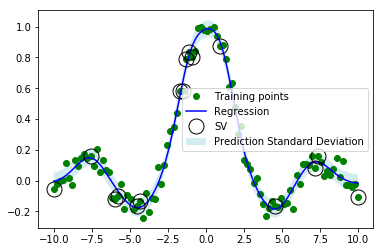

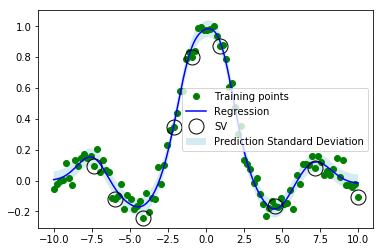

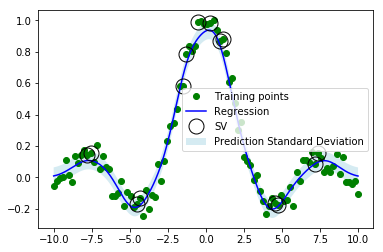

In [180]:
e_rvm_EM = 0
e_rvm_DD = 0
e_rvm_BL = 0
N_rv_EM = 0
N_rv_DD = 0
N_rv_BL = 0
N_tst = Y_tst.shape[0]
S = 1
for i in range(S):    
    rvmEM.train(X_tr, Y_tr)
    rvmDD.train(X_tr, Y_tr)
    rvmBL.train(X_tr, Y_tr)
    pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
    pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
    pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
    e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
    e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
    e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
    X_rv_EM, Y_rv_EM = rvmEM.getSV()
    X_rv_DD, Y_rv_DD = rvmDD.getSV()
    X_rv_BL, Y_rv_BL = rvmBL.getSV()
    N_rv_EM += np.shape(X_rv_EM)[0]
    N_rv_DD += np.shape(X_rv_DD)[0]
    N_rv_BL += np.shape(X_rv_BL)[0]
maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
e_rvm_EM /= S
e_rvm_DD /= S
e_rvm_BL /= S
N_rv_EM /= S
N_rv_DD /= S
N_rv_BL /= S
print("Sinc with uniform error")
print("EM error: " + str(e_rvm_EM))
print("DD error: " + str(e_rvm_DD))
print("BL error: " + str(e_rvm_BL))
print("EM Relevant vectors: " + str(N_rv_EM))
print("DD Relevant vectors: " + str(N_rv_DD))
print("BL Relevant vectors: " + str(N_rv_BL))
printTest(X_tr, Y_tr, X_tst, pred_rvm_EM, X_rv_EM, \
          Y_rv_EM, ser_EM, typeR='RVM')
printTest(X_tr, Y_tr, X_tst, pred_rvm_DD, X_rv_DD, \
          Y_rv_DD, ser_DD, typeR='RVM')
printTest(X_tr, Y_tr, X_tst, pred_BL, X_rv_BL, \
          Y_rv_BL, ser_BL, typeR='RVM')

In [170]:
X_tr, Y_tr, X_tst, Y_tst = genFriedman1()
rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = 1)
rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = 1)
rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = 1)

In [171]:
e_rvm_EM = 0
e_rvm_DD = 0
e_rvm_BL = 0
N_rv_EM = 0
N_rv_DD = 0
N_rv_BL = 0
N_tst = Y_tst.shape[0]
S = 1
for i in range(S):    
    rvmEM.train(X_tr, Y_tr)
    rvmDD.train(X_tr, Y_tr)
    rvmBL.train(X_tr, Y_tr)
    pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
    pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
    pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
    e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
    e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
    e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
    X_rv_EM, Y_rv_EM = rvmEM.getSV()
    X_rv_DD, Y_rv_DD = rvmDD.getSV()
    X_rv_BL, Y_rv_BL = rvmBL.getSV()
    N_rv_EM += np.shape(X_rv_EM)[0]
    N_rv_DD += np.shape(X_rv_DD)[0]
    N_rv_BL += np.shape(X_rv_BL)[0]
maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
e_rvm_EM /= S
e_rvm_DD /= S
e_rvm_BL /= S
N_rv_EM /= S
N_rv_DD /= S
N_rv_BL /= S
print("Friedman #1")
print("EM error: " + str(e_rvm_EM))
print("DD error: " + str(e_rvm_DD))
print("BL error: " + str(e_rvm_BL))
print("EM Relevant vectors: " + str(N_rv_EM))
print("DD Relevant vectors: " + str(N_rv_DD))
print("BL Relevant vectors: " + str(N_rv_BL))

EM error: 0.0645746113457
DD error: 0.0645941865039
BL error: 0.064293188045
EM Relevant vectors: 209.0
DD Relevant vectors: 5.0
BL Relevant vectors: 181.0


In [185]:
X_tr, Y_tr, X_tst, Y_tst = genFriedman2()
rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = 1)
rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = 1)
rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = 1)

In [186]:
e_rvm_EM = 0
e_rvm_DD = 0
e_rvm_BL = 0
N_rv_EM = 0
N_rv_DD = 0
N_rv_BL = 0
N_tst = Y_tst.shape[0]
S = 1
for i in range(S):    
    rvmEM.train(X_tr, Y_tr)
    rvmDD.train(X_tr, Y_tr)
    rvmBL.train(X_tr, Y_tr)
    pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
    pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
    pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
    e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
    e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
    e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
    X_rv_EM, Y_rv_EM = rvmEM.getSV()
    X_rv_DD, Y_rv_DD = rvmDD.getSV()
    X_rv_BL, Y_rv_BL = rvmBL.getSV()
    N_rv_EM += np.shape(X_rv_EM)[0]
    N_rv_DD += np.shape(X_rv_DD)[0]
    N_rv_BL += np.shape(X_rv_BL)[0]
maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
e_rvm_EM /= S
e_rvm_DD /= S
e_rvm_BL /= S
N_rv_EM /= S
N_rv_DD /= S
N_rv_BL /= S
print("Friedman #2")
print("EM error: " + str(e_rvm_EM))
print("DD error: " + str(e_rvm_DD))
print("BL error: " + str(e_rvm_BL))
print("EM Relevant vectors: " + str(N_rv_EM))
print("DD Relevant vectors: " + str(N_rv_DD))
print("BL Relevant vectors: " + str(N_rv_BL))

Friedman #2
EM error: 0.166252048443
DD error: 0.16659470407
BL error: 0.16490751215
EM Relevant vectors: 237.0
DD Relevant vectors: 233.0
BL Relevant vectors: 236.0


In [189]:
X_tr, Y_tr, X_tst, Y_tst = genFriedman3()
rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = 1)
rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = 1)
rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = 1)

In [190]:
e_rvm_EM = 0
e_rvm_DD = 0
e_rvm_BL = 0
N_rv_EM = 0
N_rv_DD = 0
N_rv_BL = 0
N_tst = Y_tst.shape[0]
S = 1
for i in range(S):    
    rvmEM.train(X_tr, Y_tr)
    rvmDD.train(X_tr, Y_tr)
    rvmBL.train(X_tr, Y_tr)
    pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
    pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
    pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
    e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
    e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
    e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
    X_rv_EM, Y_rv_EM = rvmEM.getSV()
    X_rv_DD, Y_rv_DD = rvmDD.getSV()
    X_rv_BL, Y_rv_BL = rvmBL.getSV()
    N_rv_EM += np.shape(X_rv_EM)[0]
    N_rv_DD += np.shape(X_rv_DD)[0]
    N_rv_BL += np.shape(X_rv_BL)[0]
maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
e_rvm_EM /= S
e_rvm_DD /= S
e_rvm_BL /= S
N_rv_EM /= S
N_rv_DD /= S
N_rv_BL /= S
print("Friedman #3")
print("EM error: " + str(e_rvm_EM))
print("DD error: " + str(e_rvm_DD))
print("BL error: " + str(e_rvm_BL))
print("EM Relevant vectors: " + str(N_rv_EM))
print("DD Relevant vectors: " + str(N_rv_DD))
print("BL Relevant vectors: " + str(N_rv_BL))

Friedman #3
EM error: 0.0529320692401
DD error: 0.0535523696463
BL error: 0.0520360429361
EM Relevant vectors: 219.0
DD Relevant vectors: 217.0
BL Relevant vectors: 238.0


In [207]:
X_tr, Y_tr, X_tst, Y_tst = genBoston()
print(Y_tst.shape)
rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = 1)
rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = 1)
rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = 1)

(206,)


In [208]:
e_rvm_EM = 0
e_rvm_DD = 0
e_rvm_BL = 0
N_rv_EM = 0
N_rv_DD = 0
N_rv_BL = 0
N_tst = Y_tst.shape[0]
S = 1
for i in range(S):    
    rvmEM.train(X_tr, Y_tr)
    rvmDD.train(X_tr, Y_tr)
    rvmBL.train(X_tr, Y_tr)
    pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
    pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
    pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
    e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
    e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
    e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
    X_rv_EM, Y_rv_EM = rvmEM.getSV()
    X_rv_DD, Y_rv_DD = rvmDD.getSV()
    X_rv_BL, Y_rv_BL = rvmBL.getSV()
    N_rv_EM += np.shape(X_rv_EM)[0]
    N_rv_DD += np.shape(X_rv_DD)[0]
    N_rv_BL += np.shape(X_rv_BL)[0]
maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
e_rvm_EM /= S
e_rvm_DD /= S
e_rvm_BL /= S
N_rv_EM /= S
N_rv_DD /= S
N_rv_BL /= S
print("Friedman #3")
print("EM error: " + str(e_rvm_EM))
print("DD error: " + str(e_rvm_DD))
print("BL error: " + str(e_rvm_BL))
print("EM Relevant vectors: " + str(N_rv_EM))
print("DD Relevant vectors: " + str(N_rv_DD))
print("BL Relevant vectors: " + str(N_rv_BL))

Friedman #3
EM error: 0.142738442241
DD error: 0.157728155326
BL error: 0.158505360632
EM Relevant vectors: 9.0
DD Relevant vectors: 9.0
BL Relevant vectors: 8.0


## Regression analysis on custom datasets

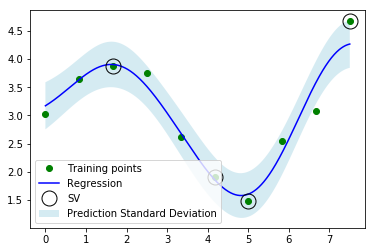

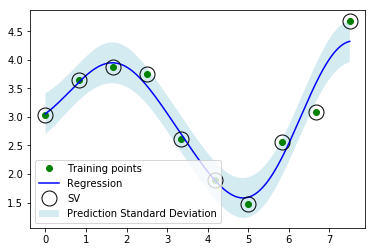

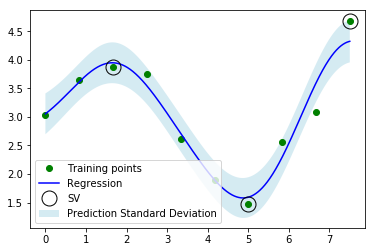

In [26]:
N_tr = 10
N_ts = 1000
x_tr = np.linspace(0,7.5,num=N_tr)
y_tr = trans(x_tr)
x_ts = np.linspace(0,7.5,num=N_ts)
y_ts = trans(x_ts)

s = RVM(kerType = "radial", p = 3, sigma = 1.1, rvmType = "SSBL")
s.train(x_tr, y_tr)
y_pred, err_val = s.pred(x_ts)
x_rv, y_rv = s.getSV()
printTest(x_tr, y_tr, x_ts, y_pred, x_rv, \
          y_rv, err_val, typeR='RVM')

s = RVM(kerType = "radial", p = 3, sigma = 1.1, rvmType = "EM")
s.train(x_tr, y_tr)
y_pred, err_val = s.pred(x_ts)
x_rv, y_rv = s.getSV()
printTest(x_tr, y_tr, x_ts, y_pred, x_rv, \
          y_rv, err_val, typeR='RVM')

s2 = RVM(kerType = "radial", p = 3, sigma = 1.1, rvmType = "DD")
s2.train(x_tr, y_tr)
y_pred, err_val = s2.pred(x_ts)
x_rv, y_rv = s2.getSV()
printTest(x_tr, y_tr, x_ts, y_pred, x_rv, \
          y_rv, err_val, typeR='RVM')